In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from math import pi, sin, inf
from scipy import polyfit
# for interactive plots:
%matplotlib notebook 
# see also matplotlib inline

# plt.rcParams["figure.figsize"] = [12,9]

from mpl_toolkits.mplot3d import Axes3D

Рассмотрим задачу Дирихле для уравнения Пуассона:
$$
\Delta u (x,y) \equiv \partial_x^2 u(x,y) + \partial_y^2 u(x,y) = f(x,y), \quad (x,y)\in \Omega := (0,1)\times (0,1) \\
u|_{\partial \Omega} = b|_{\partial \Omega}
$$
где $b\colon \overline \Omega \to \mathbb R$ --- функция, граничное значение которой задаёт граничное условие.


Будем решать эту задачу численно на равномерной сетке с $N+1$ узлом по оси $x$ и $M+1$ узлом по оси $y$ (вплоть до границы).

Обозначим $x_j = j h_x$, $h_x = \frac{1}{N}$, $j = 0, 1, ..., N$.

Обозначим $y_i = i h_y$, $h_y = \frac{1}{M}$, $i = 0, 1, ..., M$.

In [2]:
N = 4
M = 5
x = np.linspace(0,1,N+1)
print(x)
y = np.linspace(0,1,M+1)
print(y)

[ 0.    0.25  0.5   0.75  1.  ]
[ 0.   0.2  0.4  0.6  0.8  1. ]


Обозначим
$X_{i,j} = x_j$, $Y_{i,j} = y_i$, где $j = 0, 1, ..., N$ и $i = 1, ..., M$.


In [3]:
X, Y = np.meshgrid(x, y)
print(X)
print(Y)

[[ 0.    0.25  0.5   0.75  1.  ]
 [ 0.    0.25  0.5   0.75  1.  ]
 [ 0.    0.25  0.5   0.75  1.  ]
 [ 0.    0.25  0.5   0.75  1.  ]
 [ 0.    0.25  0.5   0.75  1.  ]
 [ 0.    0.25  0.5   0.75  1.  ]]
[[ 0.   0.   0.   0.   0. ]
 [ 0.2  0.2  0.2  0.2  0.2]
 [ 0.4  0.4  0.4  0.4  0.4]
 [ 0.6  0.6  0.6  0.6  0.6]
 [ 0.8  0.8  0.8  0.8  0.8]
 [ 1.   1.   1.   1.   1. ]]


Предположим, что $u(x,y) = \sin(\pi x) \cdot y \cdot (1-y)$. Тогда
$$
f(x,y) = \Delta u (x,y) = - \sin(\pi x) \cdot (\pi^2 y (1-y) + 2)
$$

In [4]:
u = np.vectorize(lambda x,y: sin(pi*x)*y*(1-y))
f = np.vectorize(lambda x,y: -sin(pi*x)*(pi*pi*y*(1-y)+2.))

Вычислим точное решение в узлах сетки.
Обратите внимание, что $u(X,Y)$ --- это матрица, у которой $(i,j)$-й элемент равен $u(x_j, y_i)$

In [5]:
print(np.around(u(X,Y),2))
print(np.around(u(x,y[1]),2))

[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.11  0.16  0.11  0.  ]
 [ 0.    0.17  0.24  0.17  0.  ]
 [ 0.    0.17  0.24  0.17  0.  ]
 [ 0.    0.11  0.16  0.11  0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[ 0.    0.11  0.16  0.11  0.  ]


Нарисуем график точного решения.
График, приведённый ниже, должен быть интерактивным.
Для неинтерактивного графика можно использовать директиву matplotlib inline

<IPython.core.display.Javascript object>


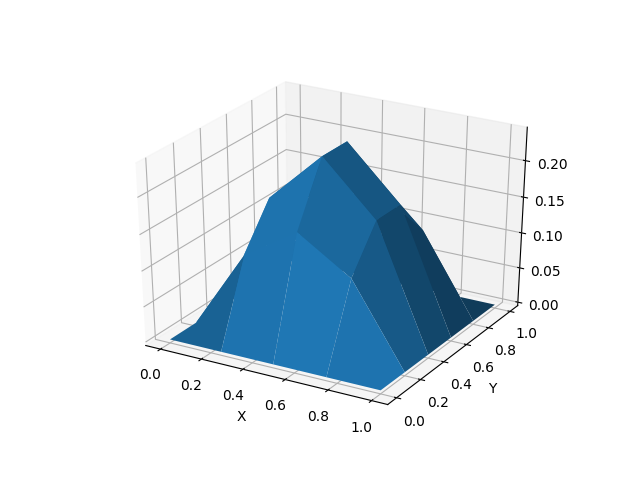

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, u(X,Y))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.view_init(azim=-60)
plt.show()

Рассмотрим разностную схему
$$
\begin{gathered}
\frac{w_{i,j-1} - 2 w_{i,j} + w_{i,j+1}}{h_x^2} +  \frac{w_{i-1,j} - 2 w_{i,j} + w_{i+1,j}}{h_y^2} = f_{i,j},
\quad 1 \le i \le M-1, \;\; 1 \le j \le N-1, 
\\
w_{i,j} = b(x_j, y_i), \quad i\in\{0, M\}, \;\; j\in \{0,N\}.
\end{gathered}\tag{1}
$$


Чтобы переписать её в виде системы линейных уравнений относительно вектора (столбца), а не матрицы, воспользуемся операцией векторизации. По определению
$$
\mathop{\mathrm{vec}}
\colon \mathbb R^{m\times n} \to \mathbb R^{mn}
$$
отображает матрицу $A$ размера $m\times n$ в столбец $a$ высоты $mn$ по правилу
$$
a_{i\cdot m + j} = A_{i,j}, \quad i=0,1,...,m-1, \;\; j = 0,1,...,n-1
$$

In [7]:
A = np.matrix([[1,2],[3,4]])
print(A)

[[1 2]
 [3 4]]


In [8]:
a = np.ravel(A, order='C')
print(a) # C-style: row major order (this is default)

[1 2 3 4]


In [9]:
print(np.ravel(A, order='F')) # Fortran-style: column major order

[1 3 2 4]


Обратное преобразование можно выполнить с помощью функции `reshape`:

In [10]:
np.reshape(a, newshape=(2,2), order='C')

array([[1, 2],
       [3, 4]])

---

Для определения и изменения граничных значений можно воспользоваться следующей функцией:

In [11]:
def edge(mat):
    m,n = np.shape(mat)
    isbdry = np.vectorize(lambda i,j: 
        i in [0, m-1] or j in [0, n-1])
    return np.fromfunction(isbdry, shape=(m,n))

In [12]:
mat = np.zeros((M,N))
print(mat)
print(edge(mat))

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ True  True  True  True]
 [ True False False  True]
 [ True False False  True]
 [ True False False  True]
 [ True  True  True  True]]


In [13]:
mat[edge(mat)] = 1
print(mat)

[[ 1.  1.  1.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 1.  1.  1.  1.]]


При использовании векторных операций для массивов, имеющих разные типы данных, можно столкнутся с не вполне ожидаемым поведением:

In [14]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
b=np.array([[-0.5,-2,-3],[-4,-5,-6],[-7,-8,-9]])
I=np.array([[True, True, True], [True, False, True], [True, True, True]])
b[I]
a[I] = b[I]
a

array([[ 0, -2, -3],
       [-4,  5, -6],
       [-7, -8, -9]])

---

Напомним, что [кронекеровским (тензорным) произведением](https://en.wikipedia.org/wiki/Kronecker_product) матриц $A\in \mathbb R^{m\times n}$ и $B \in \mathbb R^{p \times q}$ называется матрица $C\in \mathbb R^{mp \times nq}$, которая получается из матрицы $A$ заменой для каждых $i,j$ элемента $a_{i,j}$ на блок $a_{i,j} B$:
$$
C_{ip+k, jq+l} = A_{ij} B_{kl}, \qquad i=0,1,...,m-1, \quad j=0,1,...,n-1, \quad k = 0,1,...,p-1, \quad l = 0,1,...,q-1
$$
Пишут $C = A \otimes B$.

Например, матрицы $X$ и $Y$, определённые выше с помощью `meshgrid`, можно записать через тензорное произведение так:
$$
X = 1_y^T \otimes x, \qquad Y = y^T \otimes 1_x
$$
где $x,y$ --- строки с узлами сеток, определённые выше, а $1_x$ и $1_y$ --- строки, которые получаются из $x$ и $y$ заменой каждого элемента на 1. Верхний индекс $T$ обозначает транспонирование.

Важным свойством Кронекеровского (тензорного) произведения матриц является следующее утверждение.
Пусть $A\in \mathbb R^{m\times m}$ и $B \in \mathbb R^{n\times n}$ и $W\in \mathbb R^{m\times n}$. Тогда
$$
(A\otimes B) \cdot \mathop{\mathrm{vec}} W = R,
$$
где
$$
R_{in+j} = \sum_{k=0}^{m-1} \sum_{l=0}^{n-1} A_{ik} B_{jl} W_{kl}
$$
В частности, при $A = I$ (единичная матрица)
$$
R_{in+j} = \sum_{l=0}^{n-1} B_{jl} W_{il}
$$
Например, если 
$$
B_{jl} = \frac{1}{h_x^2} \begin{cases}
1, & l=j-1\\
-2, & l=j\\
1, & l=j+1\\
0, & \text{иначе}
\end{cases}$$
то при $i\ne 0$, $i\ne m$, $j\ne 0$ и $j\ne n$
$$
R_{im+l} = \frac{W_{i,j-1} - 2 W_{i,j} + W_{i,j+1}}{h_x^2}
$$
Отсюда видно, что левую часть разностной схемы (1) можно записать в виде $F \cdot \mathop{\mathrm{vec}}(W)$, где
$$
F = I_y \otimes D^2_x + D^2_y \otimes I_x + B,
$$
где 

 - $B$ --- оператор который в граничных узлах сетки возвращает значение $W$ в них, а во внутренних узлах сетки обращается в нуль.
 Оператор $B$ можно задать в виде тензорного произведения:
 $$
 B_{x,y} = \max(\mathrm{Id}_y \otimes \Gamma_x + \Gamma_y \otimes \mathrm{Id}_x,1),
 $$
 где максимум берётся поэлементно.
 - $D^2_x$ --- одномерный оператор второй производной во внутренних узлах сетки.
 - $\mathrm{Id}_y$ --- единичная матрица того же размера, что и массив $y$.
 - $I_y$ --- одномерный оператор, совпадающий с единичной матрицей во внутренних узлах сетки, и обращающийся в нуль в граничных узлах.
 - $\Gamma_y:= \mathrm{Id}_y - I_y$ --- одномерный оператор взятия граничного значения.

In [15]:
def D2(x):
    n = len(x)
    A = sp.diags([1,-2,1],[-1,0,1], shape=(n,n))
    h = x[1]-x[0]
    A = A/h/h
    A = A.tolil()
    A[0,0], A[0,1] = 0, 0
    A[-1,-2], A[-1,-1] = 0, 0
    return A

def Id(x):
    n = len(x)
    A = sp.identity(n)
    A = A.tolil()
    return A

def Id_interior(x):
    n = len(x)
    A = sp.identity(n)
    A = A.tolil()
    A[0,0] = 0
    A[-1,-1] = 0
    return A

def Id_boundary(x):
    n = len(x)
    A = sp.lil_matrix((n,n))
    A[0,0] = 1
    A[-1,-1] = 1
    return A

def Bdry(x,y):
    m = len(y)
    n = len(x)
    isbdry = np.vectorize(lambda i,j: 
        i in [0, m-1] or j in [0, n-1])
    mat = np.fromfunction(isbdry, shape=(m,n))
    B = sp.spdiags([np.ravel(mat)], 0, m*n, m*n)
    B = B.tolil()
    return B

Для визуализации структуры матрицы можно отобразить её ненулевые элементы с помощью функции `spy`:

<IPython.core.display.Javascript object>


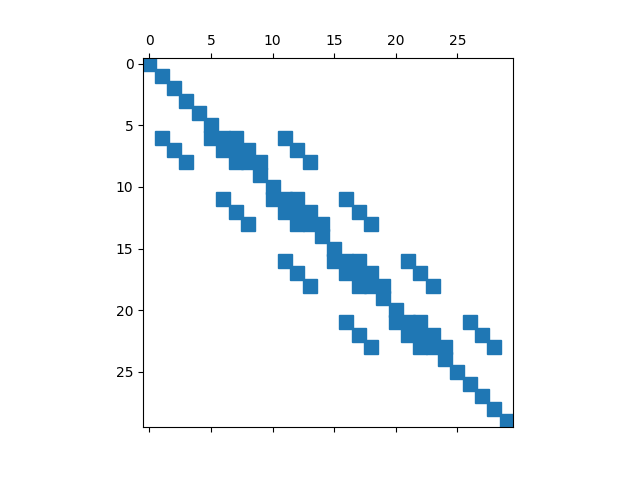

In [16]:
F = sp.kron(Id_interior(y), D2(x)) + sp.kron(D2(y), Id_interior(x)) + Bdry(x,y)
plt.figure()
plt.spy(F);

### Задача 1
Напишите функцию `poisson2d(M, N, f)`, которая реализует разностную схему (1) с $b=0$ и возвращает матрицы $X, Y$ и $W$ размера $(M+1)\times(N+1)$.
Значения элементов $W$ должны соответствовать значениям `u(X,Y)` точного решения в узлах сетки.

In [17]:
def poisson2d(M, N, f):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,M+1)
    X, Y = np.meshgrid(x, y)
    u = np.vectorize(lambda x,y: 0)
    W = u(X,Y)
    return X,Y,W

### Задача 2
Напишите функцию `poisson2d(M, N, f, b)`, которая реализует разностную схему (1) и возвращает матрицы $X, Y$ и $W$ размера $(M+1)\times(N+1)$.
Значения элементов $W$ должны соответствовать значениям `u(X,Y)` точного решения в узлах сетки.